# Tree sequence workshop

### Friday 14 December

Welcome to the tree sequence workshop. Today we will give you an overview of the tree sequence data structure, the $\texttt{msprime}$ coalescent simulator, and our scalable inference framework: $\texttt{tsinfer}$. 

# Outline

1. [The tree sequence format](#ts)
2. [Simulations with msprime and slim](ts_workshop_part2.ipynb#msprime)
3. [Calculating statistics with tree sequences](ts_workshop_part2.ipynb#stats)
4. [Inferring tree sequences (tsinfer)](ts_workshop_part3.ipynb#tsinfer)
5. [Metadata in tree sequences](ts_workshop_part3.ipynb#metadata)
6. [References and Documentation](ts_workshop_part3.ipynb#ref)

In [60]:
from IPython.display import SVG, display, HTML
import msprime as tskit # NB allows use of future terminology e.g. tskit.load()

In [61]:
%%html
<style>aside {color:grey;}</style>

<a id='ts'></a>
# 1. The tree sequence format

A succint tree sequence is an efficient way of storing the ancestry of different parts of the genome. It can be used to store the output of evolutionary simulations, or to store an ancestry inferred from real data.

The primary benefits to this are:
1. Tree sequences provide an extremely efficient way to store *and* to access genetic data (i.e. they are [succinct data structures](https://en.wikipedia.org/wiki/Succinct_data_structure))

2. Tree sequences store ancestry rather than variation data (although the second can be trivially generated from the first). In other words, they reflect the evolutionary process rather than the genetic sequence which results from this process. Not only is this more meaningful, but for simulated tree sequences it also results in precision and efficiency gains, and for inferred tree sequences we hope it will lead to novel analytical approaches.

3.  There now exist efficient tools for evolutionary simulation and ancestral inference which produce tree sequences. In particular, these include the following
> * Software for simulating tree sequences:
>> * Reverse time (coalescent) simulators: **`msprime`**
>> * Forward time simulators: **`SLiM`** (easiest), **`fwdpp`** (experimental, faster)
> * Software for inferring tree sequences from real data
>> * **`tsinfer`**

4. There are built-in routines that simplify tree sequences to the minimum knowable ancestral history. This turns out to be a powerful operation.

## Terminology

A tree sequence is, as you might expect, a set of evolutionary trees, together with some associated data that specifies, for example, which branches in the trees contain individual mutations. Tree sequences can be accessed using the `tskit` python library. <aside>Currently the tree sequence operations are part of the msprime library, so functionality can be accessed by specifying `import msprime as tskit` at the top of your python script</aside>

### Nodes
Trees in a tree sequence are represented in a slightly unusual way. In the majority of libraries dealing with trees, each node is represented as an object in memory and the relationship between nodes as pointers between these objects. In tree sequences, however, all nodes, both internal and terminal, are represented by an integer ID, unique over the entire tree sequence.

The tips (leaves) of the tree, are usually marked as *sample nodes*: In most cases tips will correspond to samples with a full genetic sequence

Internal nodes represent ancestors in which a single DNA sequence was duplicated (in forwards-time terminology) or in which multiple sequences coalesced (in backwards-time terminology). 

### Edges
Edges specify a directional connection between node IDs in the tree. Since trees in a tree sequence are usually taken to represent marginal trees along a genome, as well as branches on the tree having a length (a time dimension), each branch also has a *span*, giving the length of a genome it covers.

### Genomes
A tree sequence is usually taken to cover a contiguous section of a single chromosome. For clarity of explanation, we use the word "genome" to refer to the section spanned by the whole tree sequence (if you find it easier, imagine that the examples in this notebook refer to to an organism with a single, short chromosome)

The tree below shows a pre-loaded example of a tree from a tree sequence

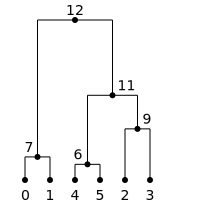

In [62]:
# Ignore this code for the moment
# This loads a tree sequence, from an existing file and plots the first tree
my_tree_seq_object = tskit.load("data/tree_seq_file1.trees")
SVG(my_tree_seq_object.first().draw())

A genealogical tree like this one records the lines of descent along which genomes have been inherited. For example, ancestral genome 7 gave rise to two lineages which ended in sample genome 0 and sample genome 1 in the current population. 

#### A note on ploidy
Since diploids have two copies of each autosomal chromosome, diploid individuals contain two such lines of descent. The tree above might therefore representing three diploid (or 6 haploid) individuals. <aside>Note that tree sequences do have a concept of an individual that can contain multiple genomes (see [here](https://msprime.readthedocs.io/en/stable/interchange.html#nodes-genomes-or-individuals)), but currently this is only used when attaching metadata to a tree sequence (something detailed in part 3: [Metadata in tree sequences](ts_workshop_part3.ipynb#metadata))</aside>.


### Trees
The example above is a single tree. We might wish to inspect all the trees in a tree sequence. The simpest way to do this is to print them one after another. Our pre-loaded example was actually from a 1kilobase tree sequence which happens to have 3 trees along the genome, one to the left, one in the middle of the DNA region, and one to the right.


In [63]:
# Ignore this code for the moment
svg_trees=[tree.draw() for tree in my_tree_seq_object.trees()]
display(HTML('<table style="border:0; text-align: center"><tr><td>{}</td></tr><tr><td colspan="{}">{}</td></tr><tr style="font-weight: bold; font-family: serif"><td style="text-align: left">{}</td><td style="text-align: center">{}</td><td style="text-align: right">{}</td></tr></table>'.format(
    "</td><td>".join(svg_trees),len(svg_trees),"<hr>",0, "genome position", 1000)))

Of course, the *sample nodes* 0..5 are present in all trees (i.e. at all genomic positions) since we have their full genomes. What you should note is that most of the *internal nodes* are also present in multiple trees: the exceptions are node 11 which is only present in the first tree, node 9 which is only present in the first two trees, and node 8 which is only present in the last tree.

However, in tree sequence terminology, we don't explictly keep track of where nodes start and end. Only edges (not nodes) possess a genomic span. So for example, this tree sequence is defined using edges like (0->7) which spans the entire genome, edges like (9->11) which only span the leftmost section of the genome, and edges like (10->12) which span the remain part of the genome. 

###Number of edges: a key tree sequence measure
Because edges can span multiple trees, they are an efficient way of storing ancestral information. In fact, the size of a tree sequence file is largely determined by the number of edges. This number can be used as a rough measure of many things such as the compressibility of a simulation, the speed with which analyses are likely to run, and even the effectiveness of ancestral inference. To give some sense of scale our inferred ancestry of human chromosome 20 in the UK Biobank dataset of a million genomes consists of 62 million edges which define 16 thousand trees; the uncompressed tree sequence takes 2.1 gigabytes of disk space, and on a reasonably specced computer it takes ~11 seconds to iterate over all these trees.

The `tskit` library allow us to use tree sequence objects in Python; these have specific properties and can also be queried using various methods. Currently these are documented in the [msprime API documentation](https://msprime.readthedocs.io/en/stable/api.html). For example, we can easily show the number of edges in a tree sequence as follows 

In [64]:
my_tree_seq_object.num_edges # a lot less than the UK Biobank!

17

and we can iterate over the edges using the `.edges()` iterator, which returns an `Edge` object:

In [65]:
for edge in my_tree_seq_object.edges():
  print(edge)

{left=0.000, right=1000.000, parent=6, child=4}
{left=0.000, right=1000.000, parent=6, child=5}
{left=0.000, right=1000.000, parent=7, child=0}
{left=0.000, right=1000.000, parent=7, child=1}
{left=480.525, right=1000.000, parent=8, child=2}
{left=480.525, right=1000.000, parent=8, child=3}
{left=0.000, right=480.525, parent=9, child=2}
{left=0.000, right=480.525, parent=9, child=3}
{left=249.237, right=1000.000, parent=10, child=6}
{left=249.237, right=1000.000, parent=10, child=7}
{left=0.000, right=249.237, parent=11, child=6}
{left=0.000, right=249.237, parent=11, child=9}
{left=0.000, right=249.237, parent=12, child=7}
{left=480.525, right=1000.000, parent=12, child=8}
{left=249.237, right=480.525, parent=12, child=9}
{left=249.237, right=1000.000, parent=12, child=10}
{left=0.000, right=249.237, parent=12, child=11}


Similarly we can iterate over other components of a tree sequence, like the trees themselves. The `.trees()` iterator  returns `SparseTree` objects, which we can `.draw()` to SVG or in unicode text format, which is how we produced the plots above. <aside>To encourage efficiency, there no in-built provision to jump directly into the middle of a tree sequence. To obtain a tree at a particular point in the genome, you need to iterate through the trees until you identify the one that you want.</aside>

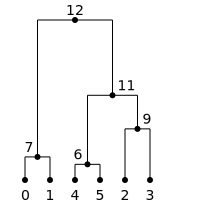

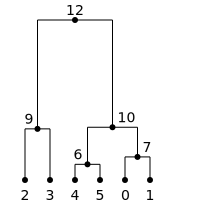

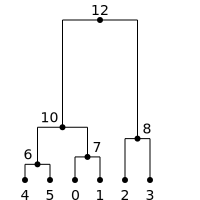

In [66]:
for tree in my_tree_seq_object.trees():
    display(SVG(tree.draw()))

### Tree changes, ancestral recombinations, and SPRs

Note that adjacent trees in this tree sequence differ by a single "tree edit" or SPR (subtree-prune-and-regraft) operation: the subtree defined by node 6 in the first tree has been pruned and regrafted onto the edge from (12->7) to create the second tree. See if you can work out the SPR that converts the second tree to the third tree... 

In general, each detectable recombination occurring in ancestral history results in a single SPR in the tree sequence. If, as above, recombination breakpoints occurs at unique positions (an "infinite sites" model of breakpoints), then the number of trees in a tree sequence equals the number of ancestral recombination events minus one. If recombinations can occur at the same physical position (e.g. if a simulation is [run using a recombination map with finite loci](https://msprime.readthedocs.io/en/stable/api.html#msprime.RecombinationMap.uniform_map), then moving from one tree to the next in a tree sequence might require multiple SPRs, because there are multiple, overlaid ancestral recombination events.

<aside>If you are moving from tree to tree, but only need to work out what changed each time, you can use the .edge_diffs() method on the tree sequence. Investigating this is left as an excercise for the reader.</aside>

## Tables: the underlying data store

The underlying data in tree sequences is stored as a set of tables. For example, there is a node table and an edges table (documented [here](https://msprime.readthedocs.io/en/stable/api.html#tables-api)). Asceesing tree sequence data via tables is simetimes an alternative to using the built-in methods and properties of `TreeSequence` objects. It is more complex, but also more powerful. For example, as the documentation states:
<blockquote><code>TreeSequences</code> are immutable. To change the data held in a particular tree sequence, first get the table information as a <code>TableCollection</code> instance (using <code>dump_tables()</code>), edit those tables using the tables api, and create a new tree sequence using <code>TableCollection.tree_sequence()</code>.</blockquote>
In summary, since a tree sequence object is entirely specified by tables, these provide access to the guts of a stored tree sequence.

In [69]:
print(my_tree_seq_object.tables)


############################################################
#   Individuals                                            #
############################################################
id	flags	location	metadata
############################################################
#   Nodes                                                  #
############################################################
id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	0	-1	0.00000000000000	
4	1	0	-1	0.00000000000000	
5	1	0	-1	0.00000000000000	
6	0	0	-1	2311.62912471615846	
7	0	0	-1	3403.44472285223856	
8	0	0	-1	6100.64244196680283	
9	0	0	-1	7539.11962928479534	
10	0	0	-1	7777.12552144685378	
11	0	0	-1	12490.33157918277175	
12	0	0	-1	23590.26953715075069	
############################################################
#   Edges                                                  #
############################################################
id

## Tree sequences and ARGs
Much of the literature on full ancestral inference concentrates on the Ancestral Recombination Graph, or ARG. A tree sequence is essentially a compact representation of an ARG. The main difference is that ARGs store details of the position and potentially the timing of recombination events, whereas tree sequences simply store the trees created by these events. Some but not all details of the actual recombination events can be inferred from the edge differences along a tree sequence. As we state in the [tsinfer paper](https://www.biorxiv.org/content/early/2018/11/01/458067)
<blockquote>an ARG encodes the events that occurred in the history of a sample, whereas a tree sequence encodes the outcome of those events</blockquote>